In [1]:
using JLD2, CairoMakie
using Jchemo, JchemoData
using Loess

In [2]:
path_jdat = dirname(dirname(pathof(JchemoData)))
db = joinpath(path_jdat, "data/tecator.jld2")
@load db dat
pnames(dat)

(:X, :Y)

In [3]:
X = dat.X
Y = dat.Y
ntot = nro(X)

178

In [4]:
@head X

... (178, 100)
 


Row,850,852,854,856,858,860,862,864,866,868,870,872,874,876,878,880,882,884,886,888,890,892,894,896,898,900,902,904,906,908,910,912,914,916,918,920,922,924,926,928,930,932,934,936,938,940,942,944,946,948,950,952,954,956,958,960,962,964,966,968,970,972,974,976,978,980,982,984,986,988,990,992,994,996,998,1000,1002,1004,1006,1008,1010,1012,1014,1016,1018,1020,1022,1024,1026,1028,1030,1032,1034,1036,1038,1040,1042,1044,1046,1048
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,2.62964,2.63245,2.63565,2.63933,2.64353,2.64825,2.6535,2.65937,2.66585,2.67281,2.68008,2.68733,2.69427,2.70073,2.70684,2.71281,2.71914,2.72628,2.73462,2.74416,2.75466,2.76568,2.77679,2.7879,2.79949,2.81225,2.82706,2.84356,2.86106,2.87857,2.89497,2.90924,2.92085,2.93015,2.93846,2.94771,2.96019,2.97831,3.00306,3.03506,3.07428,3.11963,3.16868,3.21771,3.26254,3.29988,3.32847,3.34899,3.36342,3.37379,3.38152,3.38741,3.39164,3.39418,3.3949,3.39366,3.39045,3.38541,3.37869,3.37041,3.36073,3.34979,3.33769,3.32443,3.31013,3.29487,3.27891,3.26232,3.24542,3.22828,3.2108,3.19287,3.17433,3.15503,3.13475,3.11339,3.09116,3.0685,3.04596,3.02393,3.00247,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.8596,2.8394,2.8192
2,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.8606,2.86566,2.87093,2.87661,2.88264,2.88898,2.89577,2.90308,2.91097,2.91953,2.92873,2.93863,2.94929,2.96072,2.97272,2.98493,2.9969,3.00833,3.0192,3.0299,3.04101,3.05345,3.06777,3.08416,3.10221,3.12106,3.13983,3.1581,3.17623,3.19519,3.21584,3.23747,3.25889,3.27835,3.29384,3.30362,3.30681,3.30393,3.297,3.28925,3.28409,3.28505,3.29326,3.30923,3.33267,3.36251,3.39661,3.43188,3.46492,3.49295,3.51458,3.53004,3.54067,3.54797,3.55306,3.55675,3.55921,3.56045,3.56034,3.55876,3.55571,3.55132,3.54585,3.5395,3.53235,3.52442,3.51583,3.50668,3.497,3.48683,3.47626,3.46552,3.45501,3.44481,3.43477,3.42465,3.41419,3.40303,3.39082,3.37731,3.36265,3.34745,3.33245,3.31818,3.30473,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.196,3.17942
3,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,2.60414,2.60714,2.61029,2.61361,2.61714,2.62089,2.62486,2.62909,2.63361,2.63835,2.6433,2.64838,2.65354,2.6587,2.66375,2.6688,2.67383,2.67892,2.68411,2.68937,2.6947,2.70012,2.70563,2.71141,2.71775,2.7249,2.73344,2.74327,2.75433,2.76642,2.77931,2.79272,2.80649,2.82064,2.83541,2.85121,2.86872,2.88905,2.91289,2.94088,2.97325,3.00946,3.0478,3.08554,3.11947,3.14696,3.16677,3.17938,3.18631,3.18924,3.1895,3.18801,3.18498,3.18039,3.17411,3.16611,3.15641,3.14512,3.13241,3.11843,3.10329,3.08714,3.07014,3.05237,3.03393,3.01504,2.99569,2.97612,2.95642,2.9366,2.91667,2.89655,2.87622,2.85563,2.83474,2.81361,2.79235,2.77113,2.75015,2.72956,2.70934,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816


In [5]:
@head Y

... (178, 4)
 


Row,water,fat,protein,typ
,Float64,Float64,Float64,String
1,60.5,22.5,16.7,train
2,46.0,40.1,13.5,train
3,71.0,8.4,20.5,train


In [6]:
summ(Y)

(res = 4×7 DataFrame
 Row │ variable  mean    std     min   max   n      nmissing 
     │ Symbol    Union…  Union…  Any   Any   Int64  Int64    
─────┼───────────────────────────────────────────────────────
   1 │ water     63.046  9.784   39.3  76.6    178         0
   2 │ fat       18.378  12.629  0.9   49.1    178         0
   3 │ protein   17.634  2.996   11.0  21.8    178         0
   4 │ typ                       test  val     178         0, ntot = 178)

In [7]:
namy = names(Y)[1:3]

3-element Vector{String}:
 "water"
 "fat"
 "protein"

In [8]:
typ = Y.typ
tab(typ)

OrderedCollections.OrderedDict{String, Int64} with 3 entries:
  "test"  => 31
  "train" => 115
  "val"   => 32

In [9]:
wl = names(X)
wl_num = parse.(Float64, wl)

100-element Vector{Float64}:
  850.0
  852.0
  854.0
  856.0
  858.0
  860.0
  862.0
  864.0
  866.0
  868.0
    ⋮
 1032.0
 1034.0
 1036.0
 1038.0
 1040.0
 1042.0
 1044.0
 1046.0
 1048.0

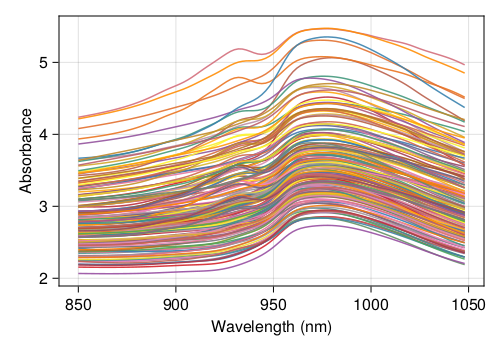

In [10]:
plotsp(X, wl_num;
    xlabel = "Wavelength (nm)", ylabel = "Absorbance").f

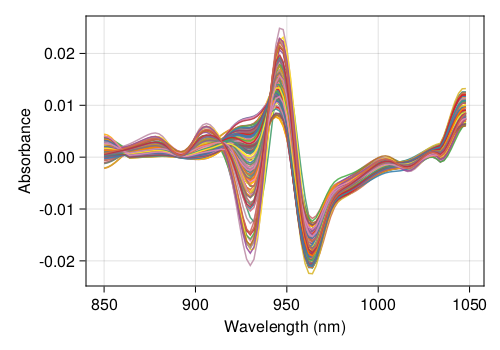

In [11]:
# Preprocessing
f = 15 ; pol = 3 ; d = 2
Xp = savgol(snv(X); f = f, pol = pol, d = d)

plotsp(Xp, wl_num;
    xlabel = "Wavelength (nm)", ylabel = "Absorbance").f

In [12]:
# Split Tot = Train + Test
# The model is tuned on Train, and
# the generalization error is estimated on Test.
# Here the split of Tot is provided by the dataset
# (= variable 'typ'), but Tot could be split
# a posteriori (e.g. random sampling, systematic
# sampling, etc.)
s = typ .== "train"
Xtrain = Xp[s, :]
Ytrain = Y[s, namy]
Xtest = rmrow(Xp, s)
Ytest = rmrow(Y[:, namy], s)
ntrain = nro(Xtrain)
ntest = nro(Xtest)
ntot = ntrain + ntest
(ntot = ntot, ntrain, ntest)

(ntot = 178, ntrain = 115, ntest = 63)

In [13]:
# Work on the second y-variable
j = 2
nam = namy[j]    # y-variable
ytrain = Ytrain[:, nam]
ytest = Ytest[:, nam]

63-element Vector{Float64}:
 29.8
  1.4
  4.6
 11.0
 17.0
 22.4
 27.9
 46.5
  6.1
  2.0
  ⋮
 18.1
 19.4
 24.8
 27.2
 28.4
 31.3
 33.8
 35.5
 42.5

In [14]:
# Model fitting
nlv = 15
fm = plskern(Xtrain, ytrain; nlv = nlv) ;
pnames(fm)

(:T, :P, :R, :W, :C, :TT, :xmeans, :xscales, :ymeans, :yscales, :weights, :niter)

In [15]:
# Predictions
pred = Jchemo.predict(fm, Xtest).pred

63×1 Matrix{Float64}:
 28.058435935995767
  1.8059651842086204
  2.2971353606371956
  8.578470708338081
 14.310096431514665
 18.966517422352617
 23.109582252070787
 48.4506463671835
  8.533355667381436
  1.9906398019329323
  ⋮
 16.915817180198797
 17.58281580537225
 20.828305439358505
 28.011404101568246
 25.64868822832667
 35.368890178763266
 32.699891450709046
 37.721274606393116
 44.68176782236763

In [16]:
Jchemo.predict(fm, Xtest; nlv = 2).pred

63×1 Matrix{Float64}:
 27.14280079992953
  3.3717801390922713
  6.0841761504839855
 10.693226384288927
 15.186111814712383
 19.071015182104155
 24.820318926686525
 53.36347009554271
  9.540081805136651
  3.790703992882511
  ⋮
 16.768490990553907
 17.158780192006574
 20.877580100391807
 25.88681490792031
 26.505064819329625
 30.051264182216443
 33.424179957985395
 36.85307791183288
 46.55110318357841

In [17]:
Jchemo.predict(fm, Xtest; nlv = 0:2).pred

3-element Vector{Matrix{Float64}}:
 [18.358260869565218; 18.358260869565218; … ; 18.358260869565218; 18.358260869565218;;]
 [26.353438531759277; 3.5783474660036276; … ; 35.28277824165846; 44.653102737314384;;]
 [27.14280079992953; 3.3717801390922713; … ; 36.85307791183288; 46.55110318357841;;]

In [18]:
rmsep(pred, ytest)

1×1 Matrix{Float64}:
 2.2224756041606337

In [19]:
bias(pred, ytest)

1×1 Matrix{Float64}:
 -0.4081002705408465

In [20]:
mse(pred, ytest)

Row,nam,msep,rmsep,sep,bias,cor2,r2,rpd,rpdr,mean
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,y1,4.939,2.222,2.185,-0.408,0.971,0.969,5.702,6.821,18.414


In [21]:
r = residreg(pred, ytest) # residuals

63×1 Matrix{Float64}:
  1.7415640640042334
 -0.4059651842086205
  2.302864639362804
  2.421529291661919
  2.6899035684853345
  3.433482577647382
  4.790417747929212
 -1.9506463671835022
 -2.433355667381436
  0.009360198067067671
  ⋮
  1.1841828198012045
  1.8171841946277496
  3.9716945606414953
 -0.8114041015682467
  2.751311771673329
 -4.068890178763265
  1.100108549290951
 -2.2212746063931164
 -2.1817678223676324

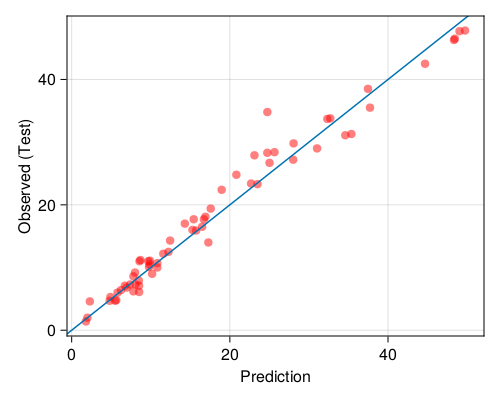

In [22]:
# Plotting predictions vs. observed data zr = vec(r)
zpred = vec(pred)
plotxy(zpred, ytest; resolution = (500, 400),
    color = (:red, .5), bisect = true,
    xlabel = "Prediction", ylabel = "Observed (Test)").f

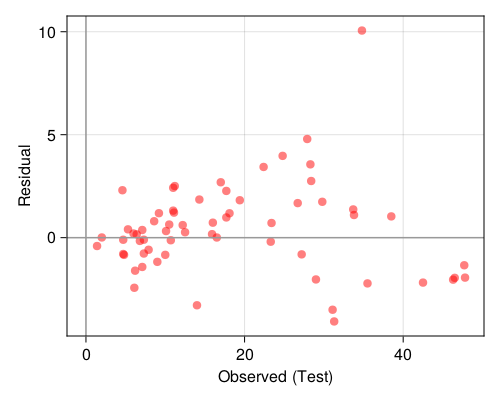

In [23]:
zr = vec(r)
plotxy(ytest, zr; resolution = (500, 400),
    color = (:red, .5), zeros = true,
    xlabel = "Observed (Test)", ylabel = "Residual").f

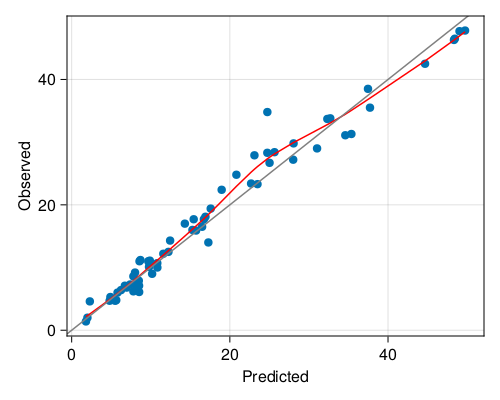

In [24]:
# Adding a smoothing
f, ax = plotxy(zpred, ytest;
    xlabel = "Predicted", ylabel = "Observed",
    resolution = (500, 400))
zfm = loess(zpred, ytest; span = 2/3) ;
pred_loess = Loess.predict(zfm, sort(zpred))
lines!(ax, sort(zpred), pred_loess; color = :red)
ablines!(ax, 0, 1; color = :grey)
f

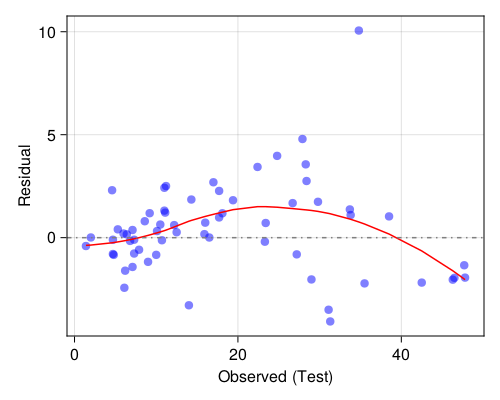

In [25]:
f, ax = plotxy(ytest, zr; color = (:blue, .5),
    resolution = (500, 400),
    xlabel = "Observed (Test)", ylabel = "Residual")
zfm = loess(ytest, zr; span = 2/3) ;
pred_loess = Loess.predict(zfm, sort(ytest))
lines!(ax, sort(ytest), pred_loess; color = :red)
hlines!(ax, 0; color = :grey, linestyle = :dashdot)
f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*